# Methylation and accessibility prediction on amplicons using NN models for each base individually

21/06/03

A compilation of code from other notebooks that is used in this method, so that it can all be run together.

Before this notebook:
* Use Data_Processing.ipynb to generate scripts for pacbio processing. Run these on wynton.
* Included in the scripts is to run extractIPDfull3.py. This will generate \*full.pickle files for each sample

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
from Bio import Seq, SeqIO
import socket

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

if 'biochem1' in socket.gethostname():
    dataPBase = '/avicenna/vramani/analyses/pacbio/'
    figPBase = '/avicenna/cmcnally/pbanalysis/'
if 'assembler4' in socket.gethostname():
    dataPBase = '/data/users/goodarzilab/colin/results/pacbio/'
if 'wynton' in socket.gethostname():
    dataPBase = '/wynton/group/goodarzilab/ramanilab/results/pacbio/'
if 'rumi' in socket.gethostname():
    raise Exception('no pacbio results folder on rumi')
    
# load in reference sequences for both the independent and dependent CTCF sites
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_independent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    irefseq = record.seq # reference sequence for independent CTCF site
refFile = dataPBase + 'pbrun10_CTCFpool_2/snf2h_dependent_site_observed.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    drefseq = record.seq # reference sequence for dependent CTCF site

# Load in the sample reference tables for the CTCF site samples
sampleRef = pd.read_csv(dataPBase + 'pbrun10_CTCFpool_2/pbrun10_CTCFpool_2.sampleReference.csv')
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + 'pbrun10_CTCFpool_1/pbrun10_CTCFpool_1.sampleReference.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210516_NA_SNF2hCTCFarray_ST_rep2/210516_NA_SNF2hCTCFarray_ST_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210520_NA_SNF2hCTCFarray_MT_rep1/210520_NA_SNF2hCTCFarray_MT_rep1.sampleReference.wynton.csv')],
                      ignore_index=True)
sampleRef = pd.concat([sampleRef,
                       pd.read_csv(dataPBase + '210608_NA_SNF2hCTCFarray_MT_rep2/210608_NA_SNF2hCTCFarray_MT_rep2.sampleReference.wynton.csv')],
                      ignore_index=True)

del sampleRef['index']

indepSamples = np.nonzero([(name[0:5] == 'Indep' or name[0:8] == 'CTCF_Ind') for name in sampleRef['sampleName']])[0]
depSamples = np.nonzero([(name[0:5] == 'Depen' or name[0:8] == 'CTCF_Dep') for name in sampleRef['sampleName']])[0]

In [ ]:
# Alternatively, for Widom molecules

amplicon = 'widom'
sampleRef =  pd.read_csv(dataPBase + 'pbrun3-9_SampleReference.csv')

samp = 44
for ir, record in enumerate(SeqIO.parse(sampleRef['reference'][samp], 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    wrefseq = record.seq

In [ ]:
pd.set_option('display.max_rows', 100)
sampleRef

## Step 1: Perform dimensionality reduction on molecules using non-adenine bases
The resulting components capture variation in IPD patterns between molecules, and will be used in step 2 to adjust the expectations for IPD measurements from unmethylated adenines in different molecules

In [10]:
def latentifyMakeNNinput(cellname, sampname, refseq, svdmodel=None):
    with open(os.path.join(dataPBase, cellname,'processed','full', 
                       cellname + '_' + sampname + '_full.pickle'), 'rb') as fin:
        ipds = pickle.load(fin, encoding="latin1")
    
    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
    
    notaFor = np.logical_or.reduce([refis['A'],refis['C'],refis['G']])
    notaRev = np.logical_or.reduce([refis['T'],refis['C'],refis['G']])
    nfor = np.sum(notaFor)
    nrev = np.sum(notaRev)

    notaipd = np.full((len(ipds), (nfor + nrev)), np.nan, dtype=np.float32)

    for i in range(len(ipds)):
        notaipd[i, 0:nfor] = ipds[i]['fmean'][notaFor]
        notaipd[i, nfor:(nfor+nrev)] = ipds[i]['rmean'][notaRev]
        
    notaipd = notaipd - np.nanmean(notaipd, axis=0)
    indices = np.nonzero(~np.isnan(notaipd))
    sparsem = coo_matrix( (notaipd[indices], indices), shape=notaipd.shape)
    sparsem = csr_matrix(sparsem)
    
    if svdmodel is None:
        svdmodel = TruncatedSVD(n_components=40, n_iter=20, random_state=33)
        svdmodel.fit(sparsem)
        pcvars = svdmodel.transform(sparsem)
    else:
        pcvars = svdmodel.transform(sparsem)
        
    stpcvars = pcvars - pcvars.mean(axis=0)
    stpcvars = stpcvars / stpcvars.std(axis=0)
    
    onlyATref = [b for b in refseq if b == 'A' or b == 'T']
    refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

    aipd = np.full((len(ipds), len(onlyATref)), np.nan, dtype=np.float32)
    for i in range(len(ipds)):
        aipd[i, refisonly['T']] = ipds[i]['fmean'][refis['T']]
        aipd[i, refisonly['A']] = ipds[i]['rmean'][refis['A']]
    
    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]
    if not os.path.exists(dataPBase + '%s/processed/forNN' % (cellname)):
        os.makedirs(dataPBase + '%s/processed/forNN' % (cellname))
    # write nn input file
    np.savez(os.path.join(dataPBase, cellname,'processed','forNN',
                           cellname + '_' + sampname + '_forNNsimple.npz'), 
             aipd = aipd,
             stpcvars = stpcvars, 
             abaseInd = abaseInd)
        
    return svdmodel

In [10]:
# independent site samples

samp = 1 # the independent site naked unmethylated control
isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq)

for samp in tqdm(indepSamples):
    isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq, isvdmod)
    
# dependent site samples

samp = 3 # the dependent site naked unmethylated control
dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq)

for samp in tqdm(depSamples):
    dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq, dsvdmod)
    
svdModelD = {}
svdModelD['independent'] = isvdmod
svdModelD['dependent'] = dsvdmod

with open('/data/users/goodarzilab/colin/models/CTCFsites/svdModels.pickle', 'wb') as fout:
    pickle.dump(svdModelD, fout)

100%|██████████| 34/34 [05:05<00:00,  8.99s/it]


In [15]:
with open('/data/users/goodarzilab/colin/models/CTCFsites/svdModels.pickle', 'rb') as fin:
    svdModelD = pickle.load(fin)
    
redoInd = indepSamples[indepSamples >= 72]
redoDep = depSamples[depSamples >= 72]

for samp in tqdm(redoInd, position=0):
    isvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], irefseq, svdModelD['independent'])
    
for samp in tqdm(redoDep, position=0):
    dsvdmod = latentifyMakeNNinput(sampleRef['cell'][samp], sampleRef['sampleName'][samp], drefseq, svdModelD['dependent'])

100%|██████████| 12/12 [02:04<00:00, 10.37s/it]


## Step 2: Fit a regression to IPD in unmethylated control samples and subtract that expectation from measurements to get residuals

In [17]:
############ Alternate model that predicts all bases at once

# now use NN to get residuals
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

def getResiduals(samp, model=None, suffix=''):

    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','forNN',
                              sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_forNNsimple.npz')) as data:
        aipd = data['aipd']
        pcvars = data['stpcvars']

    if model is None:
                    
        pcv_input = keras.layers.Input(shape=pcvars.shape[1:])
        lay1 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(pcv_input)
        drop1 = keras.layers.Dropout(0.5)(lay1)
        lay2 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop1)
        drop2 = keras.layers.Dropout(0.5)(lay2)
        lay3 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop2)
        drop3 = keras.layers.Dropout(0.5)(lay3)
        lay4 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop3)
        drop4 = keras.layers.Dropout(0.5)(lay4)
        outputs = keras.layers.Dense(aipd.shape[1])(drop4)
        model = keras.models.Model(inputs=[pcv_input],
                                       outputs=[outputs])
        model.compile(loss="mean_squared_error", optimizer="Adam")
    
        mol = np.nonzero(np.sum(np.isnan(aipd), axis=1) == 0)[0]
        
        
        history = model.fit([pcvars[mol,:]], aipd[mol, :],
                            epochs=100, batch_size=128, shuffle=True, verbose=0)

    pred = model.predict(pcvars, batch_size=512)
    resid = aipd - pred
        
    if not os.path.exists(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/NNres' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                           sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals'
                          + suffix + '.npz'),
             residuals = resid)
    
    return model


In [6]:
# widom
amplicon = 'widom'
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}

samp = 44
imodel = getResiduals(samp)

for samp in tqdm(useSamples[amplicon]):
    if samp == 44:
        continue
    imodel = getResiduals(samp, imodel)
    
if not os.path.exists(dataPBase + 'pbrun6/processed/NNmodels'):
        os.makedirs(dataPBase + 'pbrun6/processed/NNmodels')
        
imodel.save(dataPBase + 'pbrun6/processed/NNmodels/NNresid_widom_model')

100%|██████████| 7/7 [00:22<00:00,  3.21s/it]


In [7]:
samp = 1
imodel = getResiduals(samp)
    
for samp in tqdm(indepSamples):
    if samp == 1:
        continue
    imodel = getResiduals(samp, imodel)
    
if not os.path.exists(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels'):
        os.makedirs(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels')
        
imodel.save(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_indep_model')
    
# not dependent site samples
samp = 3
dmodel = getResiduals(samp)
    
for samp in tqdm(depSamples):
    if samp == 3:
        continue
    dmodel = getResiduals(samp, dmodel)
        
dmodel.save(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_dep_model')


100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


In [19]:
imodel = keras.models.load_model(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_indep_model')
dmodel = keras.models.load_model(dataPBase + 'pbrun10_CTCFpool_2/processed/NNmodels/NNresid_dep_model')

redoInd = indepSamples[indepSamples >= 72]
redoDep = depSamples[depSamples >= 72]

for samp in tqdm(redoInd, position=0):
    imodel = getResiduals(samp, imodel)

for samp in tqdm(redoDep, position=0):
    dmodel = getResiduals(samp, dmodel)

100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


## Step 3: Use mixture models to set cutoffs for methylation for each adenine
For each adenine in the amplicon reference, fit a two-component t-distribution mixture model to a mixture of residuals from unmethylated controls and fully methylated control DNA. Find a cutoff between methylated and unmethylated residuals based on this mixture. Measure the goodness of fit and quality of the cutoff using a variety of metrics and then set filters to exclude adenines for which no good cutoff seems possible. Output the resulting methylation predictions.

In [ ]:
# Now load in NN residuals for positive and negative controls

refs = {'indep':irefseq, 'dep':drefseq} #, 'widom':wrefseq}
posControl = {'indep':0, 'dep':2, 'widom':45}
negControl = {'indep':1, 'dep':3, 'widom':44}

amplicon = 'dep'

refseq = refs[amplicon]
refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

residuals = []
sampleOr = []

for samp in [posControl[amplicon],negControl[amplicon]]:
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        residuals.append(data['residuals'])
        sampleOr.append(np.full((data['residuals'].shape[0],1), samp))

In [39]:
# new t-distribution mixture variant

import smm
from scipy.stats import t
import warnings
from sklearn.exceptions import ConvergenceWarning

minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]])

smmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[]}

smmFitd = {}

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm1 = smm.SMM(1, tol=1e-6)
        smm1.fit(usedat)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000)
        smm2.fit(usedat)
    smmFitd[b] = smm2
    
    xfine = np.linspace(0,1,1001)
    preda = smm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    lowcut = preda[0,1]
    
    lowcomp = smm2.means_.flatten().argmin()
    highcomp = 1 - lowcomp
    
    smmfd['basei'].append(b)
    smmfd['threshold'].append(cutoff)
    smmfd['meanlow'].append(smm2.means_[lowcomp][0])
    smmfd['meanhigh'].append(smm2.means_[highcomp][0])
    smmfd['weighthigh'].append(smm2.weights_[highcomp])
    smmfd['lowcut'].append(lowcut)
    smmfd['lowprob'].append(smm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,highcomp])
    smmfd['aicd'].append(smm1.aic(usedat) - smm2.aic(usedat))
    smmfd['cutoff'].append(cutoff)
    
smmfd = pd.DataFrame(smmfd)

100%|██████████| 1762/1762 [1:30:55<00:00,  3.10s/it]


In [8]:
# new measurement, look at rate of calling in pos and neg control for the cutoff

posfrac = []
negfrac = []

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    pdat = residuals[0][:,b]
    usepdat = pdat[~np.isnan(pdat)]
    
    posfrac.append(np.mean(usepdat > smmfd['cutoff'][b]))
    
    ndat = residuals[1][:,b]
    usendat = ndat[~np.isnan(ndat)]
    
    negfrac.append(np.mean(usendat > smmfd['cutoff'][b]))

posfrac = np.array(posfrac)
negfrac = np.array(negfrac)

100%|██████████| 1762/1762 [00:01<00:00, 1557.05it/s]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


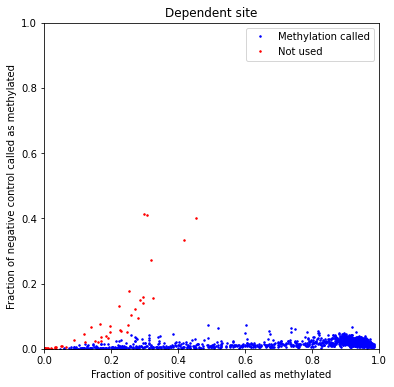

In [9]:
titleD = {'indep':'Independent site', 'dep':'Dependent site'}

plt.figure(figsize=(6,6))
plt.plot(posfrac[goodbase], negfrac[goodbase], 'b.', ms=3, label='Methylation called')
plt.plot(posfrac[badbase], negfrac[badbase], 'r.', ms=3, label='Not used')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fraction of positive control called as methylated')
plt.ylabel('Fraction of negative control called as methylated')
plt.title(titleD[amplicon])
plt.legend()
plt.savefig('/data/users/goodarzilab/colin/Figures/smmControlFrac_' + amplicon + '.png', dpi=300)

0

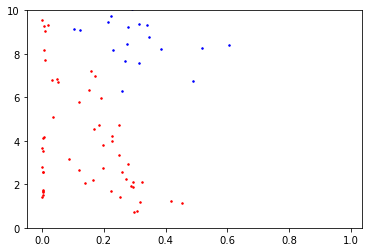

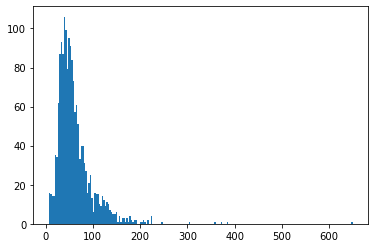

In [10]:
plt.plot(posfrac[goodbase], posfrac[goodbase]/negfrac[goodbase], 'b.', ms=3, label='Methylation called')
plt.plot(posfrac[badbase], posfrac[badbase]/negfrac[badbase], 'r.', ms=3, label='Not used')
plt.ylim([0,10])
plt.figure()
plt.hist(posfrac[goodbase]/negfrac[goodbase], 200)
0

In [40]:
dfrac = []
for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    dfrac.append( np.mean( usedat > smmfd['cutoff'][b]))
dfrac = np.array(dfrac)

100%|██████████| 1762/1762 [00:00<00:00, 2768.14it/s]


0

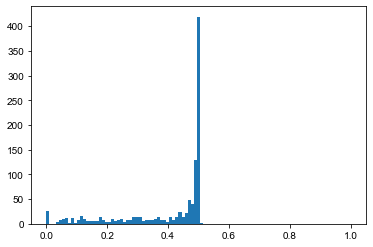

In [27]:
plt.hist(dfrac, np.linspace(0,1,100))
0

In [41]:
if amplicon == 'indep':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.2,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])

if amplicon == 'dep':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.1,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])
    
if amplicon == 'widom':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.3,
                                      smmfd['meanhigh'] > 0,
                                      dfrac > 0.02])
    
goodbase = np.nonzero(passfilt)[0]
badbase = np.nonzero(~passfilt)[0]
    
print(len(goodbase))
print(len(badbase))

1698
64


In [42]:
# now apply threshhold to all samples
#useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}
useSamples = {'indep':np.append([0,1], redoInd), 'dep':np.append([2,3], redoDep), 'widom':[3, 44, 45, 47, 48, 51, 52]}
for samp in tqdm(useSamples[amplicon], position=0):
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','NNres',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_residuals.npz')) as data:
        resid = data['residuals']
        
    methbin = np.full(resid.shape, np.nan, dtype=np.float32)
    
    for b in range(methbin.shape[1]):
        if b in goodbase:
            hasmeasure = ~np.isnan(resid[:,b])
            methbin[hasmeasure,b] = resid[hasmeasure,b] > smmfd['threshold'][b]
            
    if not os.path.exists(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp]))
        
    np.savez(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz'),
             methpred = methbin)

100%|██████████| 14/14 [00:28<00:00,  2.06s/it]


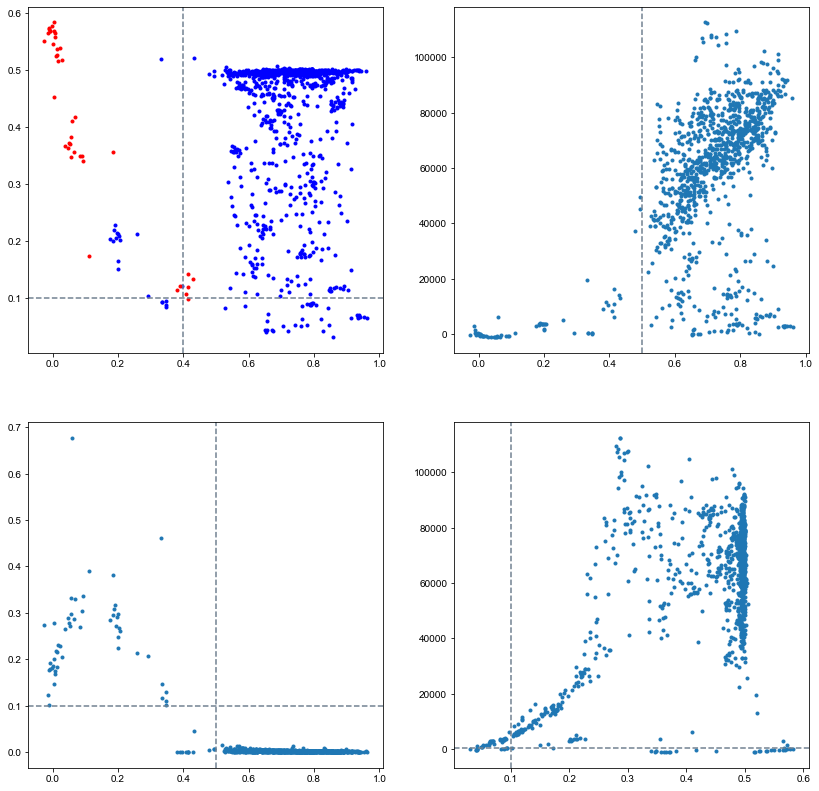

In [21]:
fig, ax = plt.subplots(2,2, figsize=(14,14))
ax[0,0].plot(smmfd['meanhigh'][goodbase], smmfd['weighthigh'][goodbase], 'b.')
ax[0,0].plot(smmfd['meanhigh'][badbase], smmfd['weighthigh'][badbase], 'r.')
ax[0,0].axvline(x=0.4, ls='--', color='slategray')
ax[0,0].axhline(y=0.1, ls='--', color='slategray')

ax[0,1].plot(smmfd['meanhigh'], smmfd['aicd'], '.')
ax[0,1].axvline(x=0.5, ls='--', color='slategray')

ax[1,0].plot(smmfd['meanhigh'], smmfd['lowprob'], '.')
ax[1,0].axvline(x=0.5, ls='--', color='slategray')
ax[1,0].axhline(y=0.1, ls='--', color='slategray')


ax[1,1].plot(smmfd['weighthigh'], smmfd['aicd'], '.')
ax[1,1].axvline(x=0.1, ls='--', color='slategray')
ax[1,1].axhline(y=300, ls='--', color='slategray')


In [ ]:
## Plot lots of examples of "bad" bases, visually inspect to see that there really isn't a good potential methylation
## cutoff possible

figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(badbase[0:200], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

In [ ]:
## Plot lots of examples of "good" bases, visually inspect to see that the mixture model fit well and found a good cutoff

figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(goodbase[0:1000], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

## Step 4: Use an HMM model to classifying accessibility along each molecule


In [44]:
from pomegranate import HiddenMarkovModel, State, BernoulliDistribution


refs = {'indep':irefseq, 'dep':drefseq, 'widom':None}#wrefseq}
posControl = {'indep':0, 'dep':2, 'widom':45}
negControl = {'indep':1, 'dep':3, 'widom':44}
useSamples = {'indep':indepSamples, 'dep':depSamples, 'widom':[3, 44, 45, 47, 48, 51, 52]}

amplicon = 'indep'

refseq = refs[amplicon]
possamp = posControl[amplicon]
negsamp = negControl[amplicon]

bins = {}
for samp in useSamples[amplicon]:
    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz')) as data:
        bins[samp] = data['methpred']

goodInd = np.sum(np.isnan(bins[negsamp]), axis=0) < bins[negsamp].shape[0]

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

goodBase = abaseInd[goodInd]

goodIndInd = np.nonzero(goodInd)[0]


# Find the probability of each good base being methylated in negative and positive controls  
posmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins[possamp][:,i])
        posmprob[i] = (np.sum(bins[possamp][hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

negmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins[negsamp][:,i])
        negmprob[i] = (np.sum(bins[negsamp][hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

# construct the model using these probabilities
AcAd = []
InacAd = []

for ib, b in enumerate(goodIndInd):
    AcAd.append(State(BernoulliDistribution(posmprob[b]), name="Ac_{0}".format(ib)))
    InacAd.append(State(BernoulliDistribution(negmprob[b]), name="Inac_{0}".format(ib)))
    
model = HiddenMarkovModel()
model.add_states(AcAd)
model.add_states(InacAd)
model.add_transition(model.start, AcAd[0], 0.5)
model.add_transition(model.start, InacAd[0], 0.5)

for b in np.arange(len(goodIndInd)-1):
    dist = abaseInd[goodIndInd[b+1]] - abaseInd[goodIndInd[b]]
    stayInacP = (1 - 1/1000)**dist
    model.add_transition(InacAd[b], InacAd[b+1], stayInacP)
    model.add_transition(InacAd[b], AcAd[b+1], 1 - stayInacP)
    stayAcP = (1 - 1/1000)**dist
    model.add_transition(AcAd[b], AcAd[b+1], stayAcP)
    model.add_transition(AcAd[b], InacAd[b+1], 1 - stayAcP)
    
model.add_transition(AcAd[len(goodIndInd)-1], model.end, 1)
model.add_transition(InacAd[len(goodIndInd)-1], model.end, 1)
model.bake()

In [46]:
# For each molecule, use the observed methylation to solve the most likely state path through the HMM

useSamples = {'indep':redoInd, 'dep':redoDep}
for samp in useSamples[amplicon]:

    with np.load(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                               sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_NNsimple_binarized_SMM.npz')) as data:
        bins[samp] = data['methpred']
        
    refbases = np.arange(len(refseq))
    hmmRes = np.full((bins[samp].shape[0], len(refseq)), np.nan)
    for im in tqdm(np.arange(bins[samp].shape[0]), position=0, smoothing=0.001, mininterval=20,
                   desc=sampleRef['sampleName'][samp]):

        path = model.viterbi(bins[samp][im,goodInd])

        pathRes = np.full(len(goodIndInd), np.nan)
        for p in path[1]:
            psplit = p[1].name.split('_')
            if len(psplit) > 1:
                if psplit[0] == 'Ac':
                    pathRes[int(psplit[1])] = 1
                if psplit[0] == 'Inac':
                    pathRes[int(psplit[1])] = 0

        hmmRes[im,:] = np.interp(refbases, goodBase, pathRes)
        
    if not os.path.exists(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp])):
        os.makedirs(dataPBase + '%s/processed/binarized' % (sampleRef['cell'][samp]))
        
    np.save(os.path.join(dataPBase, sampleRef['cell'][samp],'processed','binarized',
                         sampleRef['cell'][samp] + '_' + sampleRef['sampleName'][samp] + '_HMM.npy'),
            arr = hmmRes)

CTCF_Ind_5to1_plusADP_MT_rep2: 100%|██████████| 35135/35135 [1:35:22<00:00,  6.14it/s]


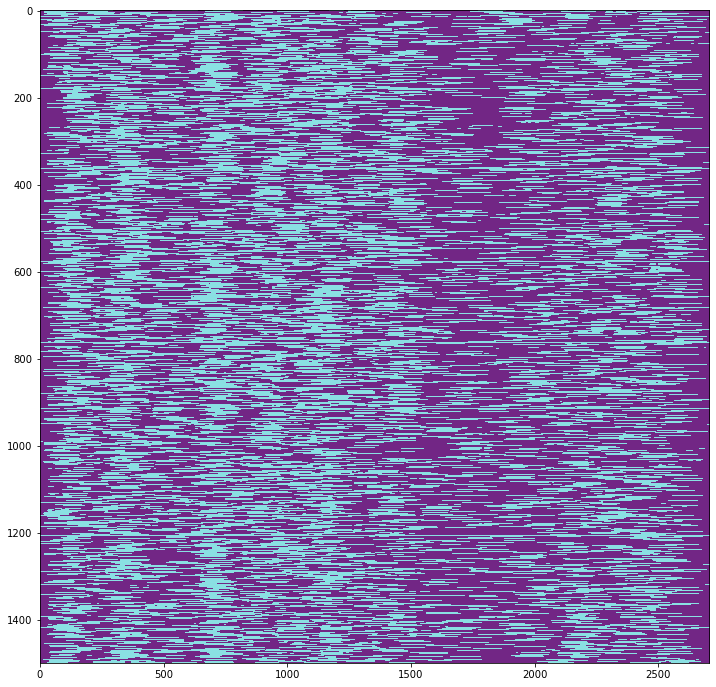

In [127]:
cmapbin = matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap', ['#8ae0e3','#722685'], 3) #['midnightblue', 'coral']
bounds = np.array([-0.5, .5, 1.5])
norm = matplotlib.colors.BoundaryNorm(bounds, cmapbin.N)

plt.figure(figsize=(12,12))
plt.imshow(hmmRes[0:1500,:], aspect='auto', interpolation='none',cmap = cmapbin, norm=norm)